# Assignment #3 Requirements 🎯

**Submission:**  
- Submit a Jupyter Notebook (`.ipynb`) file.

**Your Task:**  
- Apply Neural Style Transfer (NST) to a photo you took yourself (the content image).
- Transform your content image using any style image of your choice.

**Notebook must demonstrate:**
1. **Neural Style Transfer Implementation** 🖌️  
    - Load your own content image and a chosen style image.
    - Apply NST to generate a stylized output image.
    - Clearly display all three images (content, style, and stylized output) in your notebook.

## Submission Instructions 📥

You must submit the following files:

- **A Jupyter Notebook (.ipynb) file**  
  (The notebook should include all code, results, and visualizations.)

- **Your original content image** (`.jpg` or `.png`)  
  (A photo you took yourself.)

- **The style image** (`.jpg` or `.png`)  
  (Any style image of your choice.)

- **The stylized output image** (`.jpg` or `.png`)  
  (The result of your NST process.)

Please ensure all files are included in your submission so that your NST process and results can be fully evaluated.

**Additional Notes:**  
- You may write your own Jupyter notebook from scratch.
- Make sure to clearly indicate which images are the content, style, and output images.
- Comment your code for clarity and reproducibility.

---

**Author:** Duhyeon Kim + Perplexity (GPT4.1)


Using mps device


Optimizing Image:  10%|█         | 50/500 [00:08<01:10,  6.43iter/s, loss=558]    

Iteration: 50, loss: 565.750061


Optimizing Image:  20%|██        | 100/500 [00:17<01:19,  5.05iter/s, loss=359]

Iteration: 100, loss: 361.919556


Optimizing Image:  30%|███       | 150/500 [00:28<01:15,  4.61iter/s, loss=277]

Iteration: 150, loss: 277.251495


Optimizing Image:  40%|████      | 200/500 [00:39<01:03,  4.73iter/s, loss=230]

Iteration: 200, loss: 229.922699


Optimizing Image:  50%|█████     | 250/500 [00:49<00:41,  6.07iter/s, loss=208]

Iteration: 250, loss: 208.436157


Optimizing Image:  60%|██████    | 300/500 [00:57<00:34,  5.87iter/s, loss=197]

Iteration: 300, loss: 197.486694


Optimizing Image:  70%|███████   | 350/500 [01:06<00:24,  6.04iter/s, loss=190]

Iteration: 350, loss: 189.930237


Optimizing Image:  80%|████████  | 400/500 [01:15<00:20,  4.99iter/s, loss=185]

Iteration: 400, loss: 184.652954


Optimizing Image:  90%|█████████ | 450/500 [01:24<00:09,  5.15iter/s, loss=180]

Iteration: 450, loss: 180.494553


Optimizing Image: 100%|██████████| 500/500 [01:34<00:00,  5.01iter/s, loss=177]

Iteration: 500, loss: 177.158386


Optimizing Image: 520iter [01:38,  5.27iter/s, loss=176]                       


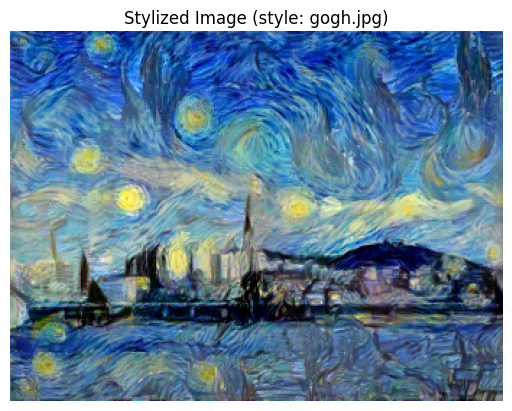

In [2]:
from vgg_redefined import VGG

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = VGG()
state_dict = torch.load(os.path.join('Models', 'vgg19-dcbb9e9d.pth'))

# make state fit for custom VGG class
custom_vgg_keys = [
    'conv1_1', 'conv1_2',
    'conv2_1', 'conv2_2',
    'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
    'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4',
    'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4'
]

vgg19_feature_indices = [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]            # all the conv layers idx in vgg-19 pretrained

new_state_dict = {}
for idx, name in enumerate(custom_vgg_keys):
    weight_key = f"{vgg19_feature_indices[idx]}.weight"
    bias_key = f"{vgg19_feature_indices[idx]}.bias"
    
    new_state_dict[f"{name}.weight"] = state_dict[weight_key]
    new_state_dict[f"{name}.bias"] = state_dict[bias_key]

# load model with new state_dict
model.load_state_dict(new_state_dict)
model.eval()
model.to(device)

# extacting features using out_keys arg in custom VGG
# with torch.no_grad():
#     r4_1, r4_2 = model(input_tensor, out_keys=['r41', 'r42'])

# ------------------------------- new -------------------------------
# Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h * w)
        G = torch.bmm(F, F.transpose(1, 2))
        G.div_(h * w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):           # input: feature map, target: Gram matrix
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

# transform settings (imaage size, mean, std)
img_size = 256
mean = [0.48501961, 0.45795686, 0.40760392]
std = [0.229, 0.224, 0.225]

pre_p = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

postpa = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(torch.tensor(std).view(-1, 1, 1)).add(torch.tensor(mean).view(-1, 1, 1)))
])

postpb = transforms.Compose([transforms.ToPILImage()])

def post_p(tensor):
    t = postpa(tensor)
    t = t.clamp(0, 1)
    img = postpb(t)
    return img

# ------------------------------- start -------------------------------
img_names = ['gogh.jpg', 'seoul.jpg']
imgs = [Image.open(name) for name in img_names]
imgs_torch = [pre_p(img).unsqueeze(0).to(device) for img in imgs]            # unsqueeze(0) is generally used to add a batch dimension
style_image, content_image = imgs_torch

# option1 : use the same image for style and content
opt_img = content_image.clone().requires_grad_(True)

#option2 : use a random noise image
# opt_img = torch.randn_like(content_image, device=content_image.device, requires_grad=True)          # using requires_grad=True to optimize the image

# (key point) all the array is sequential composed of [style1, style2, style3, content]
style_layers = ['r11', 'r21', 'r31', 'r41', 'r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers             # loss layers' last layer [-1] is the content layer

loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)       
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

style_weights = [1e8 / n ** 2 for n in [64, 128, 256, 512, 512]]
content_weights = [1e1]

weights = style_weights + content_weights       

#[GramMSELoss(), GramMSELoss() ,GramMSELoss() ,GramMSELoss() ,GramMSELoss(), nn.MSELoss()]
# [style_weights, style_weights,style_weights ,style_weights ,style_weights, content_weights]

with torch.no_grad():
    style_targets = [GramMatrix().to(device)(A) for A in model(style_image, style_layers)]        # def forward(self, x, out_keys):
    content_targets = [A for A in model(content_image, content_layers)]

targets = style_targets + content_targets
# [style_target1, style_target2, style_target3, style_target4, style_target5, content_target1]

max_iter = 500
show_iter = 50
optimizer_type = "lbfgs"

pbar = tqdm(total=max_iter, desc='Optimizing Image', unit='iter')

def visualize_stylized_image(opt_img, post_p, style_image):
    out_img = post_p(opt_img.detach()[0].cpu().squeeze())
    plt.imshow(out_img)
    plt.title(f'Stylized Image (style: {style_image})')
    plt.axis('off')
    plt.show()

try:
    if optimizer_type.lower() == "lbfgs":
        optimizer = optim.LBFGS([opt_img])
        n_iter = [0]

        while n_iter[0] <= max_iter:
            def closure():
                optimizer.zero_grad()
                out = model(opt_img, loss_layers)           # [r11, r21, r31, r41, r51, r42]
                layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
                # [GramMSELoss()(r11, style_target1), GramMSELoss()(r21, style_target2), ..., content_loss(r42, content_target1)]
                loss = sum(layer_losses)
                loss.backward()
                n_iter[0] += 1
                pbar.update(1)
                if n_iter[0] % show_iter == (show_iter - 1):
                    print('Iteration: %d, loss: %f' % (n_iter[0] + 1, loss.item()))
                    # visualize_stylized_image(opt_img, post_p, img_names[0])
                pbar.set_postfix({'loss': loss.item()})
                return loss
            optimizer.step(closure)             # cause LBFGS to call closure() multiple times

    elif optimizer_type.lower() == "adam":
        optimizer = optim.Adam([opt_img], lr=0.01)
        for i in range(max_iter):
            optimizer.zero_grad()
            out = model(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            optimizer.step()
            if i % show_iter == (show_iter - 1):
                print('Iteration: %d, loss: %f' % (i + 1, loss.item()))
                # visualize_stylized_image(opt_img, post_p, img_names[0])
            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)

    else:
        raise ValueError("optimizer_type must be 'adam' or 'lbfgs'")
    
    pbar.close()
    visualize_stylized_image(opt_img, post_p, img_names[0])

except KeyboardInterrupt:
    print("Process interrupted by user.")
    pbar.close()

## 2. Results visulization

You don't need to consider this code!

Just run the code and compare the results

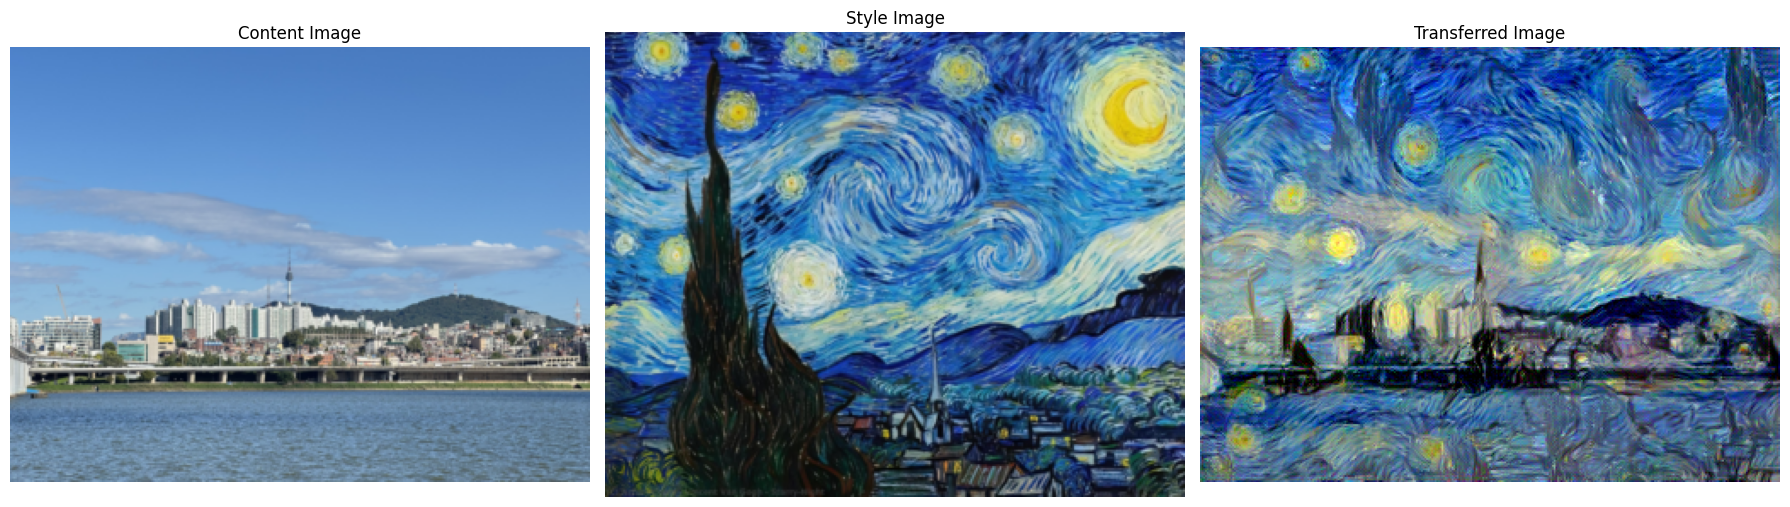

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

content_img = post_p(content_image.detach()[0].cpu().squeeze())
style_img = post_p(style_image.detach()[0].cpu().squeeze())
out_img = post_p(opt_img.detach()[0].cpu().squeeze())

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(out_img)
plt.title('Transferred Image')
plt.axis('off')

plt.tight_layout()
plt.show()
